In this assignment, you will experiment with the NYC Cab dataset from 2016. This dataset provides information (e.g., pickup/dropoff time, # of passengers, trip distance, fare) about cab trips done in New York City during 2016. You can learn more about the dataset clicking [here!](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

You will load this dataset into pandas, sqlite, and duckdb. You will compare the performance of multiple data-science like queries, including performing a fare estimation (i.e., predicting how much a ride will cost depending on distance) using machine learning.

In the first section you will implement the loader in duckdb **[5 points].**

The second section has two data-science like queries, the implementation in pandas is already given, and you should use it as a logical/correctness reference to write the queries for sqlite and duckdb, remember to compare the performance of the three different systems **[10 + 15 = 25 points]**.

Finally, in the third section you will implement a simple machine learning algorithm in duckdb to predict fare costs. A full implementation of pandas is given and a partial of sqlite. Again, use them as a logical/correctness reference and compare the performance of the three different systems. **[40 points]**

Remember to submit your notebook with the answers to all sections as well as a PDF document (max two papes) listing all experienced execution times and reasoning about the performance difference in these systems.

# **SETUP**

First we need to install duckdb.

In [1]:
!pip install duckdb --upgrade

Now we download the NYC Cab dataset as Parquet file.

In [2]:
!wget "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2016-01.parquet"

--2024-10-20 09:59:58--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2016-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 99.86.122.111, 99.86.122.230, 99.86.122.150, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|99.86.122.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151251087 (144M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2016-01.parquet’

yellow_tripdata_201 100%[===================>] 144.24M   308MB/s    in 0.5s    

2024-10-20 09:59:58 (308 MB/s) - ‘yellow_tripdata_2016-01.parquet’ saved [151251087/151251087]



# **Loading The Data** [5pts]

In this section your goal is to write code to load the data in duckdb.

First, run the code to load the data into Pandas and SQLite as provided:


In [3]:
import pandas
import sqlite3


print('\nPandas:')

# Creates Pandas Dataframe from Parquet
yellow_tripdata_pandas = pandas.read_parquet('yellow_tripdata_2016-01.parquet')

print(len(yellow_tripdata_pandas))
print(yellow_tripdata_pandas.sample(n=1))


print('\nSQLite:')

# Generates SQLite database and load data from Pandas Dataframe into table
db_sqlite = sqlite3.connect('yellow_tripdate_sqlite.db')
yellow_tripdata_pandas.to_sql('yellow_tripdata_2016_01', db_sqlite, index=False)

sqlite_cursor = db_sqlite.cursor() # Creates a Cursor, that allows us to issue SQL Stataments
print(sqlite_cursor.execute("SELECT count(*) FROM yellow_tripdata_2016_01").fetchall())
print(sqlite_cursor.execute("SELECT * FROM yellow_tripdata_2016_01 LIMIT 1").fetchall())


Pandas:
10905067
         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
8069297         2  2016-01-22 22:33:37   2016-01-22 23:01:33                5   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
8069297           4.91           1                  N           113   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
8069297           238             1         20.5    0.5      0.5        2.18   

         tolls_amount  improvement_surcharge  total_amount  \
8069297           0.0                    0.3         23.98   

        congestion_surcharge airport_fee  
8069297                 None        None  

SQLite:
[(10905067,)]
[(1, '2016-01-01T00:12:22', '2016-01-01T00:29:14', 1, 3.2, 1, 'N', 48, 262, 1, 14.0, 0.5, 0.5, 3.06, 0.0, 0.3, 18.36, None, None)]


How do we load data in DuckDB? https://duckdb.org/docs/data/overview https://duckdb.org/docs/data/parquet



In [4]:
import duckdb
import time


print('\nDuckDB:')

db = duckdb.connect('yellow_tripdata_duck.db')
duck_cursor = db.cursor()

# Replace '...' below with your DuckDB SQL query !
sql_load = """
CREATE TABLE yellow_tripdata_2016_01 AS SELECT * FROM 'yellow_tripdata_2016-01.parquet'
"""
# Replace '...' above with your DuckDB SQL query !

duck_cursor.execute(sql_load)

print(duck_cursor.execute("SELECT count(*) FROM yellow_tripdata_2016_01").fetchall())
print(duck_cursor.execute("SELECT * FROM yellow_tripdata_2016_01 LIMIT 1").fetchall())


DuckDB:
[(10905067,)]
[(1, datetime.datetime(2016, 1, 1, 0, 12, 22), datetime.datetime(2016, 1, 1, 0, 29, 14), 1, 3.2, 1, 'N', 48, 262, 1, 14.0, 0.5, 0.5, 3.06, 0.0, 0.3, 18.36, None, None)]


# **Queries** [25 pts]

**Query Q1 [10 pts]**: Count distinct values for each column.

**TIP:** We provide you with the pandas implementation, be sure to use it to check for correctness!

In the first query we want to compare the performance of a simple hash-function in our Database Management Systems (DBMSs). To do so, we implement and run a query that counts the distinct values for each column.
In general, most systems use hash-based algorithms to find the distinct values in a large set of values (e.g., a database column).
Obs: Sort-based algorithm are an alternative but usually slower.


In [5]:
import time


# SQL:
# Replace '...' below with your SQL query (The same syntax works for both SQLite and DuckDB) !
sql_01 = """
SELECT 
    COUNT(DISTINCT VendorID) AS VendorID,
    COUNT(DISTINCT tpep_pickup_datetime) AS tpep_pickup_datetime,
    COUNT(DISTINCT tpep_dropoff_datetime) AS tpep_dropoff_datetime,
    COUNT(DISTINCT passenger_count) AS passenger_count,
    COUNT(DISTINCT trip_distance) AS trip_distance,
    COUNT(DISTINCT RatecodeID) AS RatecodeID,
    COUNT(DISTINCT store_and_fwd_flag) AS store_and_fwd_flag,
    COUNT(DISTINCT PULocationID) AS PULocationID,
    COUNT(DISTINCT DOLocationID) AS DOLocationID,
    COUNT(DISTINCT payment_type) AS payment_type,
    COUNT(DISTINCT fare_amount) AS fare_amount,
    COUNT(DISTINCT extra) AS extra,
    COUNT(DISTINCT mta_tax) AS mta_tax,
    COUNT(DISTINCT tip_amount) AS tip_amount,
    COUNT(DISTINCT tolls_amount) AS tolls_amount,
    COUNT(DISTINCT improvement_surcharge) AS improvement_surcharge,
    COUNT(DISTINCT total_amount) AS total_amount,
    COUNT(DISTINCT congestion_surcharge) AS congestion_surcharge,
    COUNT(DISTINCT airport_fee) AS airport_fee 
FROM yellow_tripdata_2016_01;
"""
# Replace '...' above with your SQL query (The same syntax works for both SQLite and DuckDB) !


# Pandas:
def query_01_pandas():
  print('\nPandas:')
  print(
    yellow_tripdata_pandas['VendorID'].nunique(),
    yellow_tripdata_pandas['tpep_pickup_datetime'].nunique(),
    yellow_tripdata_pandas['tpep_dropoff_datetime'].nunique(),
    yellow_tripdata_pandas['passenger_count'].nunique(),
    yellow_tripdata_pandas['trip_distance'].nunique(),
    yellow_tripdata_pandas['RatecodeID'].nunique(),
    yellow_tripdata_pandas['store_and_fwd_flag'].nunique(),
    yellow_tripdata_pandas['PULocationID'].nunique(),
    yellow_tripdata_pandas['DOLocationID'].nunique(),
    yellow_tripdata_pandas['payment_type'].nunique(),
    yellow_tripdata_pandas['fare_amount'].nunique(),
    yellow_tripdata_pandas['extra'].nunique(),
    yellow_tripdata_pandas['mta_tax'].nunique(),
    yellow_tripdata_pandas['tip_amount'].nunique(),
    yellow_tripdata_pandas['tolls_amount'].nunique(),
    yellow_tripdata_pandas['improvement_surcharge'].nunique(),
    yellow_tripdata_pandas['total_amount'].nunique(),
    yellow_tripdata_pandas['congestion_surcharge'].nunique(),
    yellow_tripdata_pandas['airport_fee'].nunique()
  )


# SQLite:
def query_01_sqlite():
    print('\nSQLite:')
    sqlite_cursor.execute(sql_01)
    result = sqlite_cursor.fetchone()
    print(result)


# DuckDB:
def query_01_duckdb():
    print('\nDuckDB:')
    duck_cursor.execute(sql_01)
    result = duck_cursor.fetchall()
    print(result)


print('Results:')

start = time.time()
query_01_pandas()
time_pandas = time.time() - start

start = time.time()
query_01_sqlite()
time_sqlite = time.time() - start

start = time.time()
query_01_duckdb()
time_duckdb = time.time() - start

print('\nTimes:')
print('Pandas: ' + str(time_pandas))
print('SQLite: ' + str(time_sqlite))
print('DuckDB: ' + str(time_duckdb))

Results:

Pandas:
2 2368538 2372446 10 4512 7 2 261 262 5 1862 35 15 3550 939 3 11158 0 0

SQLite:
(2, 2368538, 2372446, 10, 4512, 7, 2, 261, 262, 5, 1862, 35, 15, 3550, 939, 3, 11158, 0, 0)

DuckDB:
[(2, 2368538, 2372446, 10, 4512, 7, 2, 261, 262, 5, 1862, 35, 15, 3550, 939, 3, 11158, 0, 0)]

Times:
Pandas: 4.981750249862671
SQLite: 57.429226875305176
DuckDB: 3.560697555541992




In our second query, we want to compare the performance of the aggregation/grouping functions.
**Query Q2 [15 pts]**: What's the avg/max/min frequency of events grouped by day and hour? (Recall that each record in the data set represents one event.)

**TIP_1** : Start by writing a subquery that groups the data by Day/Hour and counts all events.

For duckdb:
EXTRACT(DOY FROM tpep_pickup_datetime), EXTRACT(HOUR FROM tpep_pickup_datetime)

For Sqlite:
strftime('%j', tpep_pickup_datetime), strftime('%H', tpep_pickup_datetime) for

**TIP_2**: After writing the subquery, get the avg, min and max values of it

For your convenience, we already provide the Pandas implementation, remember to use it for correctness/logic purposes.

In [6]:
# SQLite SQL:
# Replace '...' below with your SQLite SQL query !
sql_02_sqlite = """
SELECT MIN(trips), AVG(trips), MAX(trips) 
FROM (
    SELECT 
        strftime('%j', tpep_pickup_datetime) AS day, 
        strftime('%H', tpep_pickup_datetime) AS hour, 
        COUNT(VendorID) AS trips 
    FROM yellow_tripdata_2016_01 
    GROUP BY day, hour
);
"""
# Replace '...' above with your SQLite SQL query !


# DuckDB SQL:
# Replace '...' below with your DuckDB SQL query !
sql_02_duckdb = """
SELECT MIN(trips), AVG(trips), MAX(trips) 
FROM (
    SELECT 
        EXTRACT(DAY FROM tpep_pickup_datetime) AS day, 
        EXTRACT(HOUR FROM tpep_pickup_datetime) AS hour, 
        COUNT(VendorID) AS trips 
    FROM yellow_tripdata_2016_01 
    GROUP BY day, hour
);
"""
# Replace '...' above with your DuckDB SQL query !


# Pandas:
def query_02_pandas():
    print('\nPandas:')
    df = yellow_tripdata_pandas[["VendorID", "tpep_pickup_datetime"]]
    df['day'] = pandas.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.day
    df['hour'] = pandas.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.hour
    res = df.groupby(['day', 'hour']).agg({'VendorID': 'count'})
    print(res["VendorID"].min(),res["VendorID"].mean(),res["VendorID"].max())


# SQLite:
def query_02_sqlite():
    print('\nSQLite:')
    sqlite_cursor.execute(sql_02_sqlite)
    result = sqlite_cursor.fetchall()
    print(result)


# DuckDB:
def query_02_duckdb():
    print('\nDuckDB:')
    duck_cursor.execute(sql_02_duckdb)
    result = duck_cursor.fetchall()
    print(result)


print('Results:')

start = time.time()
query_02_pandas()
time_pandas = time.time() - start

start = time.time()
query_02_sqlite()
time_sqlite = time.time() - start

start = time.time()
query_02_duckdb()
time_duckdb = time.time() - start

print('\nTimes:')
print('Pandas: ' + str(time_pandas))
print('SQLite: ' + str(time_sqlite))
print('DuckDB: ' + str(time_duckdb))

Results:

Pandas:


/tmp/ipykernel_820/396752060.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = pandas.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.day
/tmp/ipykernel_820/396752060.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = pandas.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.hour


8 14657.34811827957 28511

SQLite:
[(8, 14657.34811827957, 28511)]

DuckDB:
[(8, 14657.34811827957, 28511)]

Times:
Pandas: 1.2088637351989746
SQLite: 17.907966136932373
DuckDB: 0.19562816619873047


# **Machine Learning : Fare Estimation** [40 pts]

Here you will need to use the data to do the most basic form of machine learning: [linear regression](https://en.wikipedia.org/wiki/Ordinary_least_squares#Simple_linear_regression_model). You can train a simple estimator that takes the trip distance and estimates the price. For this exercise we provide the linear regression using pandas. Your goal is to mimic the pandas computation in both SQLite and DuckDB, and compare the computation time until the calculation of linear regression's parameters alpha and beta **(Which must be the same in all three systems, i.e., alpha and beta calculated by SQLite and DuckDB must be the same as those calculated by Pandas; take this into consideration to check if your answer is correct)**.

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

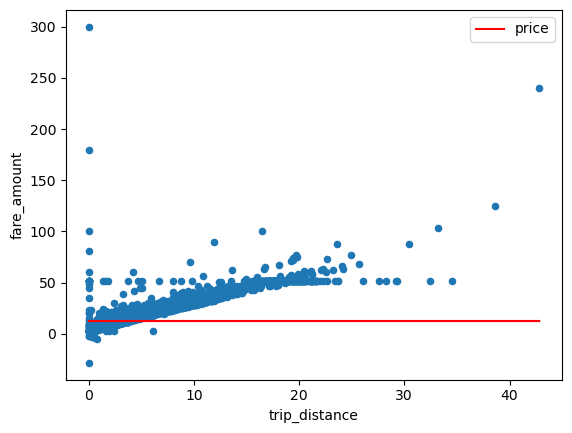

In [7]:
cov_xy = (yellow_tripdata_pandas["trip_distance"] * yellow_tripdata_pandas["fare_amount"]).sum() - (
    yellow_tripdata_pandas["trip_distance"].sum() * yellow_tripdata_pandas["fare_amount"].sum()
) / len(yellow_tripdata_pandas)
var_xy = (yellow_tripdata_pandas["trip_distance"] ** 2).sum() - yellow_tripdata_pandas["trip_distance"].sum() ** 2 / len(yellow_tripdata_pandas)
beta = cov_xy / var_xy
alpha = yellow_tripdata_pandas["fare_amount"].mean() - beta * yellow_tripdata_pandas["trip_distance"].mean()

alpha
# 12.486907739140417
beta
# 4.6752084884145456e-06

# Select some sample data and see how well we can fit the price
sample = yellow_tripdata_pandas.sample(10000)
sample["price"] = alpha + beta * sample["trip_distance"]
ax = sample.plot.scatter(x="trip_distance", y="fare_amount")
sample.plot.line(x="trip_distance", y="price", ax=ax, color="red")

As you can tell from the above image, as with any real life dataset, the New York City trip dataset also contains outliers that we need to clean to get a good regression. Hence we need to get rid of the noisy data that disturbs our basic regression example.

**Note**: The pandas program above is merely to show the dirty data/outliers, consider the following one for the rest of this section.

Alpha: 4.651616991535136
Beta: 2.661441728292328
ML Regression in Pandas: 2.142017364501953


<Axes: xlabel='trip_distance', ylabel='fare_amount'>

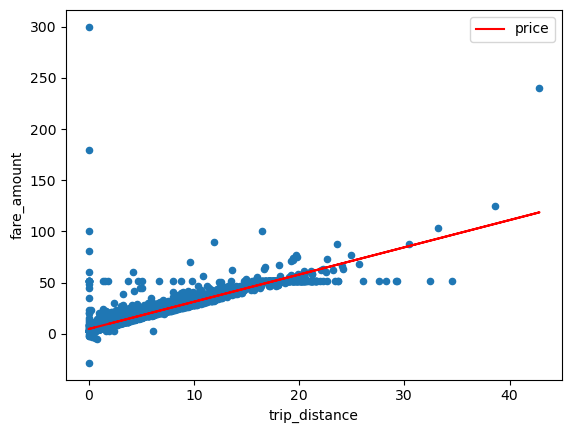

In [8]:
start = time.time()
cap_fare = yellow_tripdata_pandas["fare_amount"].mean() + 3 * yellow_tripdata_pandas["fare_amount"].std()
cap_distance = yellow_tripdata_pandas["trip_distance"].mean() + 3 * yellow_tripdata_pandas["trip_distance"].std()
df_filtered = yellow_tripdata_pandas.query(
    f"trip_distance > 0 and trip_distance < {cap_distance} and fare_amount > 0 and fare_amount < {cap_fare}"
)

# Train on the filtered data
cov_xy = (df_filtered["trip_distance"] * df_filtered["fare_amount"]).sum() - (
    df_filtered["trip_distance"].sum() * df_filtered["fare_amount"].sum()
) / len(df_filtered)
var_xy = (df_filtered["trip_distance"] ** 2).sum() - df_filtered[
    "trip_distance"
].sum() ** 2 / len(df_filtered)
beta = cov_xy / var_xy
alpha = df_filtered["fare_amount"].mean() - beta * df_filtered["trip_distance"].mean()

alpha
# 4.651606864471554
beta
# 2.661444816924383
end = time.time()
print("Alpha: " + str(alpha))
print("Beta: " + str(beta))
print("ML Regression in Pandas: " +str(end - start))
# Plot and check whether it fits better this time
sample["price"] = alpha + beta * sample["trip_distance"]
ax = sample.plot.scatter(x="trip_distance", y="fare_amount")
sample.plot.line(x="trip_distance", y="price", ax=ax, color="red")

Now, your task is to perform the same linear regression using both duckdb and sqlite.

**SQLite**:
Since SQLite doesn't have a function to compute the standard deviation and its a bit more complex than doing it in duckdb. We provide you with a solution that should be taken as inspiration for duckdb.
Here you only have to implement lines 46 and 49 to generate the samples necessary to plot a sample of the data + linear regression.

Alpha: 4.651616991535141
Beta: 2.661441728292326
ML Regression in SQLite: 13.368984699249268


<Axes: xlabel='trip_distance', ylabel='fare_amount'>

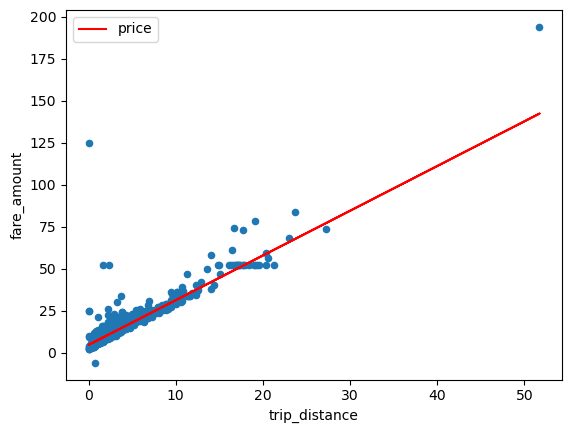

In [9]:
import math
start = time.time()
sqlite_cursor.execute("""
    SELECT
        count(*),
        sub.avg_fa as avg_fare,
        sum((fare_amount - sub.avg_fa) * (fare_amount - sub.avg_fa)) as var_fare,
        sub.avg_td as avg_distance,
        sum((trip_distance - sub.avg_td) * (trip_distance - sub.avg_td)) as var_distance
    FROM
        yellow_tripdata_2016_01,
        (
            SELECT
                AVG(fare_amount) as avg_fa,
                AVG(trip_distance) as avg_td
            FROM yellow_tripdata_2016_01
        ) as sub
""")
n, avg_fare, var_fare, avg_distance, var_distance = sqlite_cursor.fetchone()
max_fare = avg_fare + 3 * math.sqrt(var_fare / (n - 1))
max_distance = avg_distance + 3 * math.sqrt(var_distance / (n - 1))
max_fare, max_distance

sqlite_cursor.execute(f"""
SELECT
    (SUM(trip_distance * fare_amount) - SUM(trip_distance) * SUM(fare_amount) / COUNT(*)) /
    (SUM(trip_distance * trip_distance) - SUM(trip_distance) * SUM(trip_distance) / COUNT(*)) AS beta,
    AVG(fare_amount) AS avg_fare_amount,
    AVG(trip_distance) AS avg_trip_distance
FROM yellow_tripdata_2016_01
WHERE
    fare_amount > 0 AND
    fare_amount < {max_fare} AND
    trip_distance > 0 AND
    trip_distance < {max_distance}
""")
beta, avg_fare_amount, avg_trip_distance = sqlite_cursor.fetchone()
alpha = avg_fare_amount - beta * avg_trip_distance
end = time.time()
print("Alpha: " + str(alpha))
print("Beta: " + str(beta))
print("ML Regression in SQLite: " +str(end - start))


#Get a uniform random sample (size 1000) of trip_distance and fare_amount for plotting
#TIP : Use ORDER BY RANDOM() and Limit
# Replace '...' below with your SQLite SQL query !
sqlite_sample = """
SELECT trip_distance, fare_amount 
FROM yellow_tripdata_2016_01
ORDER BY RANDOM() 
LIMIT 1000;
"""
# Replace '...' above with your SQLite SQL query !

#Get a pandas dataframe from sqlite
#TIP : pandas has a function to transform sqlite query results to a dataframe
# Replace '...' below with your Pandas expression !
sqlite_df_sample = pandas.read_sql_query(sqlite_sample, db_sqlite)
# Replace '...' above with your Pandas expression !

sqlite_df_sample["price"] = alpha + beta * sqlite_df_sample["trip_distance"]
ax = sqlite_df_sample.plot.scatter(x="trip_distance", y="fare_amount")
sqlite_df_sample.plot.line(x="trip_distance", y="price", ax=ax, color="red")

**DUCKDB**

*TIP: DuckDB has a STDDEV_SAMP function (i.e., function that calculates standard deviation) and thus you can do the whole regression using one query.*

**Remember that alpha and beta calculated by your DuckDB solution MUST have the same values as the ones calculated by the Pandas solution above!**

Alpha: 4.651616991535423
Beta: 2.66144172829246
ML Regression in DuckDB: 0.42868947982788086


<Axes: xlabel='trip_distance', ylabel='fare_amount'>

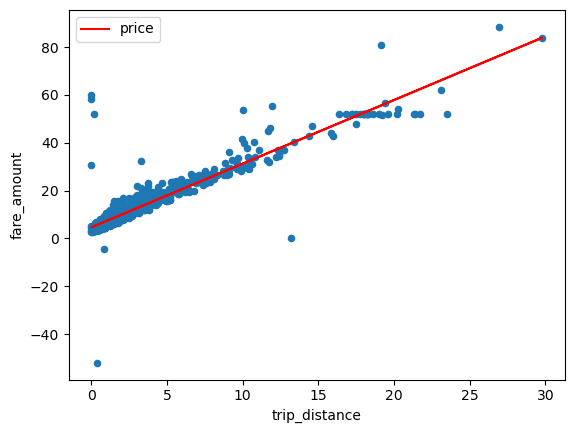

In [10]:
#Implement the regression query
# Replace '...' below with your DuckDB SQL query !
duck_regression = """
SELECT 
    covar_pop(trip_distance, fare_amount) / var_pop(trip_distance) AS beta,
    mean(fare_amount) AS avg_fare_amount,
    mean(trip_distance) AS avg_trip_distance
    
FROM (
    SELECT
        trip_distance, 
        fare_amount
    FROM yellow_tripdata_2016_01
    WHERE 
        trip_distance > 0 AND trip_distance < (
            SELECT mean(trip_distance) + 3 * stddev(trip_distance) FROM yellow_tripdata_2016_01
        )
        AND fare_amount > 0 AND fare_amount < (
            SELECT mean(fare_amount) + 3 * stddev(fare_amount) FROM yellow_tripdata_2016_01
        )
    );
"""
# Replace '...' above with your DuckDB SQL query !

start = time.time()
duck_cursor.execute(duck_regression)
#Get the values from beta and alpha from the query (replace ... for code):
# Replace '...' below with your DuckDB Python expression !
beta, avg_fare_amount, avg_trip_distance = duck_cursor.fetchone()
# Replace '...' above with your DuckDB Python expression !
alpha = avg_fare_amount - beta * avg_trip_distance
end = time.time()
print("Alpha: " + str(alpha))
print("Beta: " + str(beta))
print("ML Regression in DuckDB: " +str(end - start))
#Get a uniform random sample (size 1000) of trip_distance and fare_amount for plotting
#TIP : Use ORDER BY RANDOM() and Limit
# Replace '...' below with your DuckDB SQL query !
duck_sample = """
SELECT trip_distance, fare_amount 
FROM yellow_tripdata_2016_01
ORDER BY RANDOM() 
LIMIT 1000;
"""
# Replace '...' above with your DuckDB SQL query !

#Get a pandas dataframe from duckdb
#TIP : duckdb python's client has a function to transform query results to a dataframe
# Replace '...' below with your DuckDB Python expression !
duck_df_sample = db.sql(duck_sample).df()
# Replace '...' above with your DuckDB Python expression !

duck_df_sample["price"] = alpha + beta * duck_df_sample["trip_distance"]
ax = duck_df_sample.plot.scatter(x="trip_distance", y="fare_amount")
duck_df_sample.plot.line(x="trip_distance", y="price", ax=ax, color="red")